# Assignment 3: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [ ]:
# You might want to use the following package

import sklearn
import numpy as np
import os

from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Your code goes here for this section.

import tarfile # to support compressed (tar) files
from six.moves import urllib # support URL download

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Fetch housing data from a remote URL to Colab file system"""
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
import pandas as pd

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    """Load Housing Data into Workspace from a CSV"""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

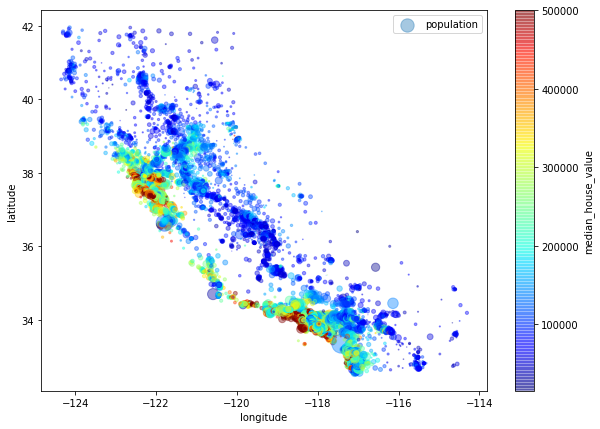

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [ ]:
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


housing = housing.dropna()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(20433, 14)

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
import random

class k_means:
   
  def __init__(self, k=2, tolerance=0.001, max_iter=500, error='euclidean'):
    self.k = k
    self.tolerance = tolerance
    self.max_iter = max_iter
    self.error = error 

  def manhattan_d(a, b):
    return np.linalg.norm(a-b,ord=1)

  def euclidean_d(a, b):
    return np.linalg.norm(a-b)

  def sup_d(a, b):
    return np.linalg.norm(a-b,ord=np.inf)


  def fit(self, data):
    self.centroids = {}

    for i in range(self.k):
      self.centroids[i] = data[i]
    
    for i in range(self.max_iter):
      self.clusters = {}
      for i in range(self.k):
        self.clusters[i] = []

      for feat in data:
        if self.error == 'manhattan':
          distance = [self.manhattan_d(feat, self.centroids[cent]) for cent in self.centroids]
          cluster = distance.index(min(distance))
          self.clusters[cluster].append(feat)
        elif self.error == 'euclidean':
          distance = [np.linalg.norm(feat - self.centroids[cent]) for cent in self.centroids]
          cluster = distance.index(min(distance))
          self.clusters[cluster].append(feat)
        elif self.error == 'sup':
          distance = [self.sup_d(feat, self.centroids[cent]) for cent in self.centroids]
          cluster = distance.index(min(distance))
          self.clusters[cluster].append(feat)
      
      old_Cent = dict(self.centroids)

      for cluster in self.clusters:
        self.centroids[cluster] = np.average(self.clusters[cluster], axis=0)

      optimal = True

      for cent in self.centroids:
        prev_Cent = old_Cent[cent]
        curr_Cent = self.centroids[cent]

        if np.sum((curr_Cent - prev_Cent)/prev_Cent*100.0) > self.tolerance:
          optimal = False

      if optimal:
        break 

  def cluster_mean(self):
    c_mean = []
    for i in range(len(self.clusters)):
      c_mean.append(np.average(self.clusters[i], axis=0))

    return c_mean
  
  def cluster_stdev(self):
    c_std = []
    for i in range(len(self.clusters)):
      c_std.append(np.std(self.clusters[i], axis=0))

    return c_std    

  def find_SSE(self):
    a = []
    for i in range(len(self.centroids)):
      c_error = 0
      for j in range(len(self.clusters[i])):
        c_error += np.linalg.norm(self.clusters[i][j] - self.centroids[i])
      a.append(c_error)

      return sum(a) 

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [ ]:
def plot_graphs(kmeans):
  colors = 10*['r', 'g', 'b', 'purple', 'c', 'y', 'm', 'brown', 'orange', 'k']
  plt.figure(figsize=(14, 12))
  for cent in kmeans.centroids:
    plt.scatter(kmeans.centroids[cent][0], kmeans.centroids[cent][1], s=130, marker='X')
  for cluster in kmeans.clusters:
    color = colors[cluster]
    for feat in kmeans.clusters[cluster]:
      plt.scatter(feat[0], feat[1], color = color, s = 30, alpha=0.4)
  plt.show

In [ ]:
from tabulate import tabulate

def data_report(list, calc):
  data_list = list.copy()
  lbl_feats = ['Cluster:', 'Longitude:', 'latitude:', 'Median Age:', 'Total # Rooms:', 'Total # Bedrooms',
            'Population:', 'Houseolds:', "Median Income:", 'Median House Value:', 'Ocean Prox1:', 
            'Ocean Prox2:', 'Ocean Prox3:', 'Ocean Prox4:', 'OceanProx5:']

  for i in range(len(data_list)):
    data_list[i] = data_list[i].tolist()
    data_list[i].insert(0, 'cluster ' + (str(i+1)))

  if calc == 'means':
    print('Feature Means:')
  else:
    print('Feature Stdevs')

  print(tabulate(data_list, lbl_feats))


In [ ]:
elbow = []

cluster1 = k_means(k=2)
cluster1.fit(housing_prepared)
elbow.append(cluster1.find_SSE())
print("Centroids: ", cluster1.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([-4.52493476e-02,  4.48037649e-02,  1.78452848e-01, -3.25583541e-01,
       -3.42564116e-01, -3.18132581e-01, -3.43035137e-01, -2.95652415e-02,
       -2.79121430e-02,  4.31837375e-01,  3.18856316e-01,  3.01604536e-04,
        1.18952829e-01,  1.30051876e-01]), 1: array([ 0.1945898 , -0.19267362, -0.76741668,  1.40013591,  1.47315899,
        1.36809389,  1.47518457,  0.12714204,  0.12003308,  0.48638132,
        0.31387808,  0.        ,  0.0773022 ,  0.12243839])}


In [ ]:
print("SSE: " + str(cluster1.find_SSE()))
data_report(cluster1.cluster_mean(), 'means')
data_report(cluster1.cluster_stdev(), 'stdev')

Inertia: 40206.53117671165
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1     -0.0452493    0.0448038       0.178453         -0.325584           -0.342564      -0.318133     -0.343035        -0.0295652             -0.0279121        0.431837        0.318856     0.000301605       0.118953        0.130052
cluster 2      0.19459     -0.192674       -0.767417          1.40014             1.47316        1.36809       1.47518          0.127142               0.120033         0.486381        0.313878     0                 0.0773022       0.12243

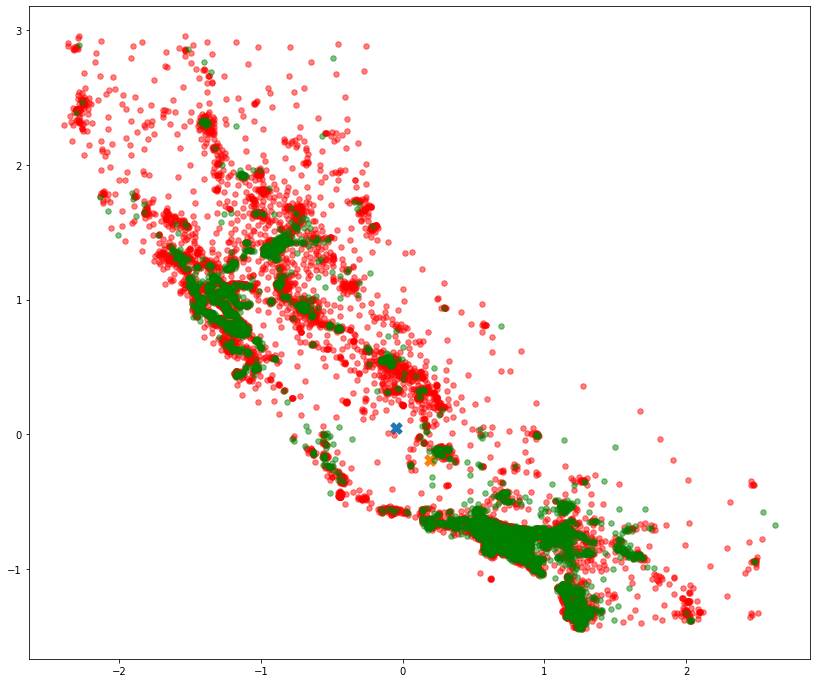

In [ ]:
plot_graphs(cluster1)

In [ ]:
cluster2 = k_means(k=3)
cluster2.fit(housing_prepared)
elbow.append(cluster2.find_SSE())
print("Centroids: ", cluster2.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([-3.99457143e-02, -1.70889084e-01,  1.46521317e-01, -4.75270190e-02,
       -2.38198570e-01, -2.81043512e-01, -2.13126166e-01,  1.14460411e+00,
        1.32873553e+00,  6.05334445e-01,  6.39716608e-02,  6.25130235e-04,
        1.61283601e-01,  1.68785164e-01]), 1: array([ 0.20293695, -0.18530106, -0.87515735,  1.86466153,  1.98495891,
        1.83221037,  1.98003583,  0.05569632,  0.042835  ,  0.46570842,
        0.337577  ,  0.        ,  0.08131417,  0.11540041]), 2: array([-2.29147649e-02,  9.63182669e-02,  1.08178827e-01, -3.26719346e-01,
       -2.79586333e-01, -2.35828808e-01, -2.87794135e-01, -4.26439552e-01,
       -4.91014854e-01,  3.78437760e-01,  4.06621714e-01,  1.51526631e-04,
        9.83407834e-02,  1.16448216e-01])}


In [ ]:
print("SSE: " + str(cluster2.find_SSE()))
data_report(cluster2.cluster_mean(), 'means')
data_report(cluster2.cluster_stdev(), 'stdev')

Inertia: 11487.730311264926
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1     -0.0399457   -0.170889        0.146521         -0.047527           -0.238199      -0.281044     -0.213126         1.1446                  1.32874         0.605334       0.0639717     0.00062513        0.161284        0.168785
cluster 2      0.202937    -0.185301       -0.875157          1.86466             1.98496        1.83221       1.98004          0.0556963               0.042835        0.465708       0.337577      0                 0.0813142       0.1154

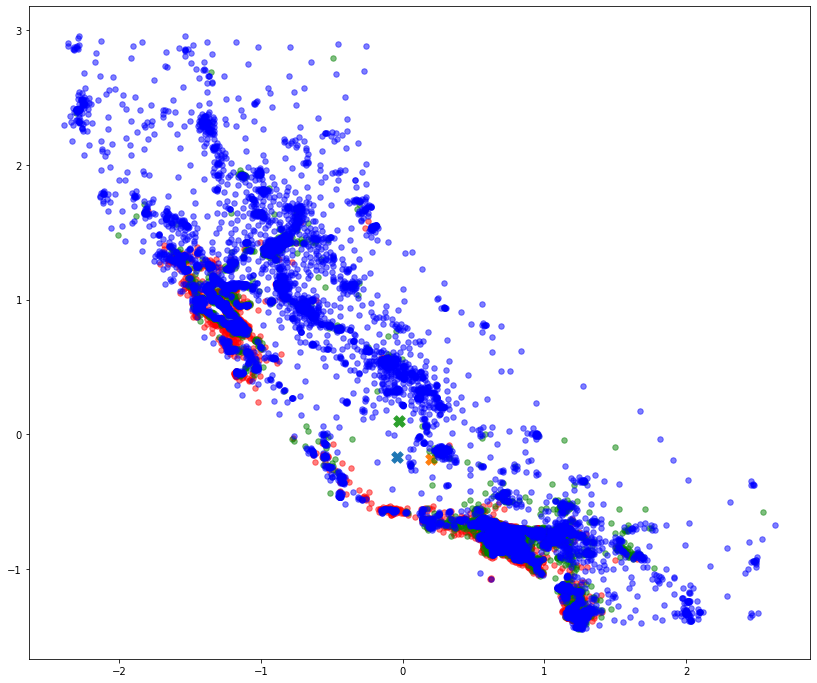

In [ ]:
plot_graphs(cluster2)                                 

In [ ]:
cluster3 = k_means(k=4)
cluster3.fit(housing_prepared)
elbow.append(cluster3.find_SSE())
print("Centroids: ", cluster3.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 1.73461118e-01, -3.69274146e-01,  3.61423262e-02,  4.27656337e-02,
       -2.09370089e-01, -2.56496700e-01, -1.88601238e-01,  1.49588528e+00,
        1.63261799e+00,  6.57711757e-01,  6.25790139e-02,  3.16055626e-04,
        1.00821745e-01,  1.78571429e-01]), 1: array([ 0.19556885, -0.16640649, -0.96630851,  2.41963624,  2.51155085,
        2.31692276,  2.50363091,  0.12538897,  0.06927461,  0.45886076,
        0.36202532,  0.        ,  0.08227848,  0.09683544]), 2: array([-1.04158423,  1.11397245,  0.0808908 , -0.23314858, -0.24025686,
       -0.27985147, -0.24983067, -0.27381019, -0.33173784,  0.15417412,
        0.50955852,  0.        ,  0.25044698,  0.08582038]), 3: array([ 7.97758279e-01, -7.92158234e-01,  9.79159105e-02, -2.68842053e-01,
       -1.85185998e-01, -9.67429737e-02, -1.83236368e-01, -3.49277944e-01,
       -3.40103510e-01,  6.06676170e-01,  2.40080779e-01,  4.75172250e-04,
        0.00000000e+00,  1.52767878e-01])}


In [ ]:
print("SSE: " + str(cluster3.find_SSE()))
data_report(cluster3.cluster_mean(), 'means')
data_report(cluster3.cluster_stdev(), 'stdev')

SSE: 7479.8384700357665
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1       0.173461    -0.369274      0.0361423         0.0427656           -0.20937       -0.256497     -0.188601          1.49589               1.63262          0.657712        0.062579     0.000316056       0.100822       0.178571
cluster 2       0.195569    -0.166406     -0.966309          2.41964              2.51155        2.31692       2.50363           0.125389              0.0692746        0.458861        0.362025     0                 0.0822785      0.0968354
cl

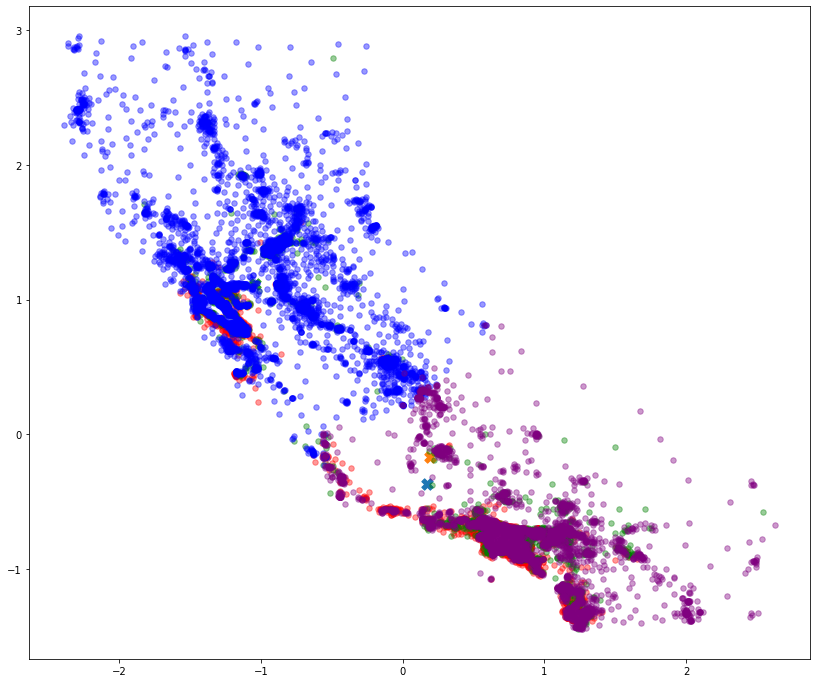

In [ ]:
plot_graphs(cluster3)

In [ ]:
cluster4 = k_means(k=5)
cluster4.fit(housing_prepared)
elbow.append(cluster4.find_SSE())
print("Centroids: ", cluster4.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 0.2062443 , -0.38927556, -0.12995065,  0.13725261, -0.24965627,
       -0.2501718 , -0.22739988,  2.40027209,  2.06002746,  0.70111288,
        0.07154213,  0.        ,  0.05564388,  0.17170111]), 1: array([ 0.19083397, -0.16787938, -0.89651832,  1.93226754,  2.05554835,
        1.90460344,  2.04918546,  0.04257275,  0.02212258,  0.46207804,
        0.35291539,  0.        ,  0.07715914,  0.10784744]), 2: array([-1.32719848,  0.97839474,  0.71895795, -0.18738451, -0.25121207,
       -0.32040753, -0.22923437,  0.39026829,  0.77564224,  0.21737537,
        0.05315249,  0.        ,  0.53445748,  0.19501466]), 3: array([ 7.97659839e-01, -8.57111158e-01,  6.30902931e-02, -2.46931515e-01,
       -2.29449506e-01, -1.84527968e-01, -2.16428492e-01,  2.35707182e-02,
        1.12086012e-01,  7.17376134e-01,  1.08583391e-01,  6.97836706e-04,
        0.00000000e+00,  1.73342638e-01]), 4: array([-0.39842635,  0.6205945 , -0.02927054, -0.32848404, -0.29214769,
       -0.2618868

In [ ]:
print("SSE: " + str(cluster4.find_SSE()))
data_report(cluster4.cluster_mean(), 'means')
data_report(cluster4.cluster_stdev(), 'stdev')

SSE: 2934.413452008154
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1       0.206244    -0.389276     -0.129951           0.137253           -0.249656      -0.250172     -0.2274           2.40027                2.06003          0.701113       0.0715421     0                 0.0556439       0.171701
cluster 2       0.190834    -0.167879     -0.896518           1.93227             2.05555        1.9046        2.04919          0.0425727              0.0221226        0.462078       0.352915      0                 0.0771591       0.107847
cl

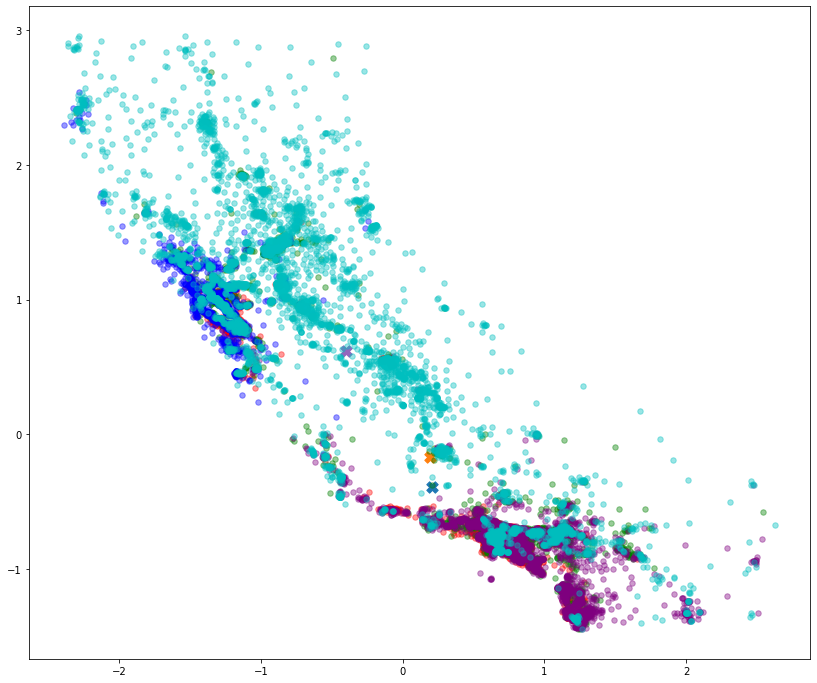

In [ ]:
plot_graphs(cluster4)

In [ ]:
cluster5 = k_means(k=6)
cluster5.fit(housing_prepared)
elbow.append(cluster5.find_SSE())
print("Centroids: ", cluster5.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 0.20762082, -0.38915741, -0.18252572,  0.20554614, -0.20954586,
       -0.20519011, -0.18505376,  2.52152516,  2.09088906,  0.70357143,
        0.06785714,  0.        ,  0.05714286,  0.17142857]), 1: array([ 0.09142821, -0.05936096, -0.97668638,  2.23335029,  2.3124432 ,
        2.11268946,  2.29992757,  0.11917046,  0.05363748,  0.43106267,
        0.37765668,  0.        ,  0.09264305,  0.0986376 ]), 2: array([-1.33440272,  0.97455383,  0.81927998, -0.18975545, -0.25458879,
       -0.33543928, -0.23261532,  0.42707458,  0.86336329,  0.18405916,
        0.0451931 ,  0.        ,  0.5673788 ,  0.20336894]), 3: array([ 0.69113569, -0.77419148,  0.01378957, -0.40719132, -0.51006002,
       -0.47369845, -0.49751077,  0.40871236,  0.40252664,  0.76515753,
        0.10669844,  0.00079428,  0.        ,  0.12734975]), 4: array([ 7.51847919e-01, -8.01077270e-01,  1.30766254e-01, -2.88778354e-02,
        1.38447554e-01,  2.25446073e-01,  1.47775930e-01, -4.26093808e-01,
  

In [ ]:
print("SSE: " + str(cluster5.find_SSE()))
data_report(cluster5.cluster_mean(), 'means')
data_report(cluster5.cluster_stdev(), 'stdev')

SSE: 2623.811298470474
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1      0.207621     -0.389157     -0.182526          0.205546            -0.209546      -0.20519      -0.185054          2.52153               2.09089          0.703571       0.0678571     0                0.0571429       0.171429
cluster 2      0.0914282    -0.059361     -0.976686          2.23335              2.31244        2.11269       2.29993           0.11917               0.0536375        0.431063       0.377657      0                0.0926431       0.0986376
clu

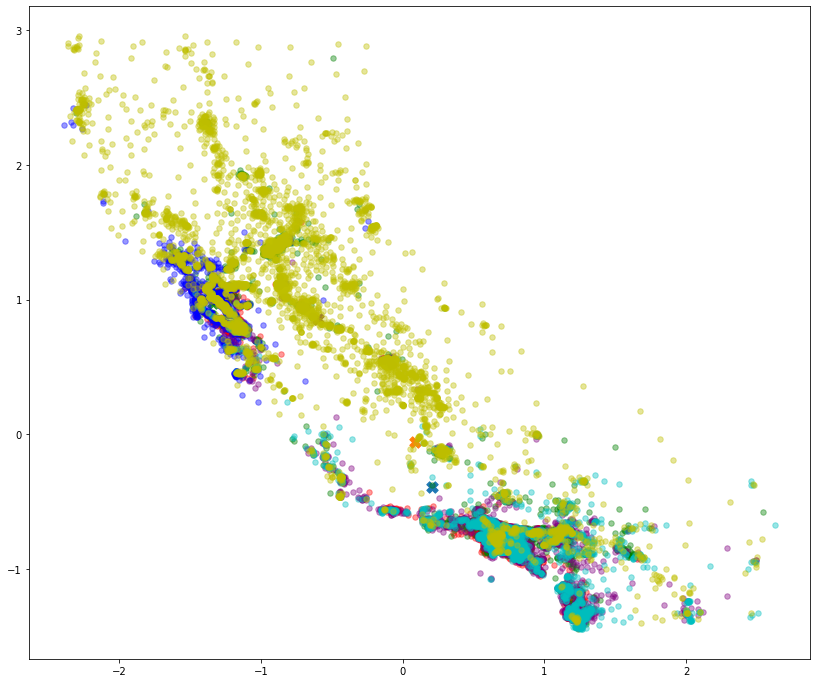

In [ ]:
plot_graphs(cluster5)

In [ ]:
cluster6 = k_means(k=7)
cluster6.fit(housing_prepared)
elbow.append(cluster6.find_SSE())
print("Centroids: ", cluster6.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 0.30882162, -0.46231389, -0.42972422,  0.21193683, -0.20876718,
       -0.18995523, -0.18764272,  2.42938025,  1.92915036,  0.70044444,
        0.08711111,  0.        ,  0.03822222,  0.17422222]), 1: array([ 0.15903871, -0.13995621, -0.93979627,  2.32306463,  2.39961178,
        2.20085601,  2.39185785,  0.15508711,  0.12290778,  0.46167247,
        0.34843206,  0.        ,  0.08536585,  0.10452962]), 2: array([-1.34243076,  0.96048771,  1.07168863, -0.13276114, -0.26737553,
       -0.35684852, -0.23708563,  0.91819341,  1.40313729,  0.0952381 ,
        0.0270936 ,  0.        ,  0.67241379,  0.20525452]), 3: array([ 0.34627796, -0.48125025, -0.02236946, -0.34507356, -0.48738473,
       -0.41833903, -0.45947903,  0.63413313,  0.37582133,  0.82142857,
        0.0725    ,  0.        ,  0.01892857,  0.08714286]), 4: array([ 0.18986975, -0.41510875,  1.0622592 , -0.30872701, -0.21691276,
       -0.41322428, -0.21611542, -0.12198168,  1.2527119 ,  0.5751938 ,
        

In [ ]:
print("SSE: " + str(cluster6.find_SSE()))
data_report(cluster6.cluster_mean(), 'means')
data_report(cluster6.cluster_stdev(), 'stdev')

SSE: 2578.8805833184806
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1       0.308822    -0.462314     -0.429724          0.211937            -0.208767      -0.189955     -0.187643          2.42938                1.92915        0.700444        0.0871111      0                0.0382222      0.174222
cluster 2       0.159039    -0.139956     -0.939796          2.32306              2.39961        2.20086       2.39186           0.155087               0.122908       0.461672        0.348432       0                0.0853659      0.10453
clus

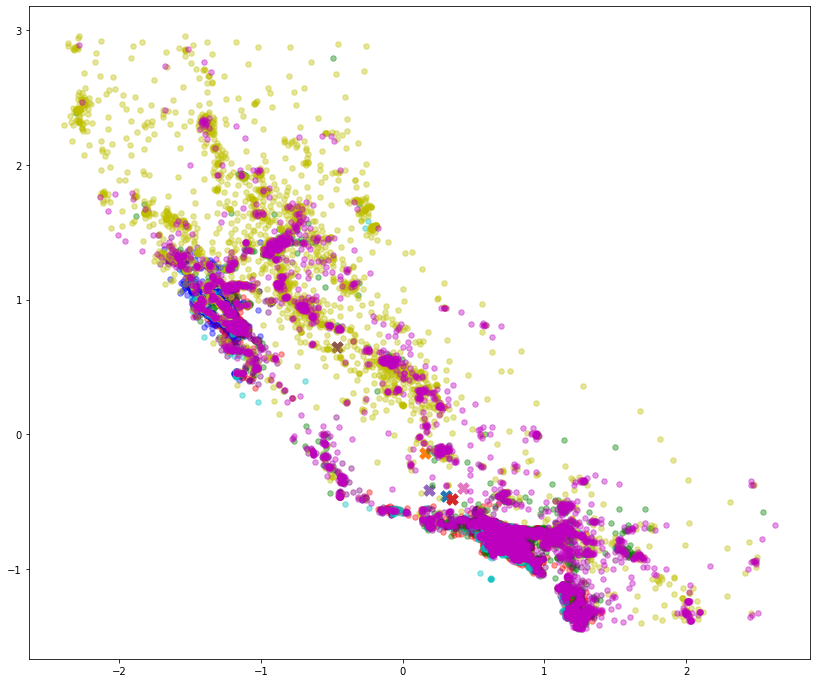

In [ ]:
plot_graphs(cluster6)

In [ ]:
cluster7 = k_means(k=8)
cluster7.fit(housing_prepared)
elbow.append(cluster7.find_SSE())
print("Centroids: ", cluster7.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 0.30567044, -0.45813662, -0.42167195,  0.20373891, -0.22158665,
       -0.20315828, -0.20230809,  2.49369261,  1.96309272,  0.69990593,
        0.08842897,  0.        ,  0.03857008,  0.17309501]), 1: array([ 0.17285997, -0.16180154, -0.95627542,  2.41392987,  2.48340136,
        2.27937847,  2.48021691,  0.17637828,  0.14426942,  0.47073474,
        0.3381071 ,  0.        ,  0.08655044,  0.10460772]), 2: array([-1.34457975,  0.95822153,  1.09032733, -0.12537987, -0.26398783,
       -0.35764944, -0.2339415 ,  0.95724672,  1.44653194,  0.0840708 ,
        0.02477876,  0.        ,  0.68849558,  0.20265487]), 3: array([ 0.11294208, -0.26596253, -0.0678279 , -0.49721044, -0.65335301,
       -0.60089936, -0.63651176,  0.83425165,  0.54398327,  0.74966622,
        0.1188251 ,  0.        ,  0.03337784,  0.09813084]), 4: array([ 0.03580637, -0.28949816,  1.13586652, -0.38133306, -0.3095252 ,
       -0.49347863, -0.31369218, -0.10852399,  1.40487916,  0.52323232,
        

In [ ]:
print("SSE: " + str(cluster7.find_SSE()))
data_report(cluster7.cluster_mean(), 'means')
data_report(cluster7.cluster_stdev(), 'stdev')

SSE: 2430.0200210171542
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1      0.30567     -0.458137      -0.421672          0.203739           -0.221587      -0.203158     -0.202308          2.49369                 1.96309        0.699906        0.088429       0                0.0385701      0.173095
cluster 2      0.17286     -0.161802      -0.956275          2.41393             2.4834         2.27938       2.48022           0.176378                0.144269       0.470735        0.338107       0                0.0865504      0.104608
clu

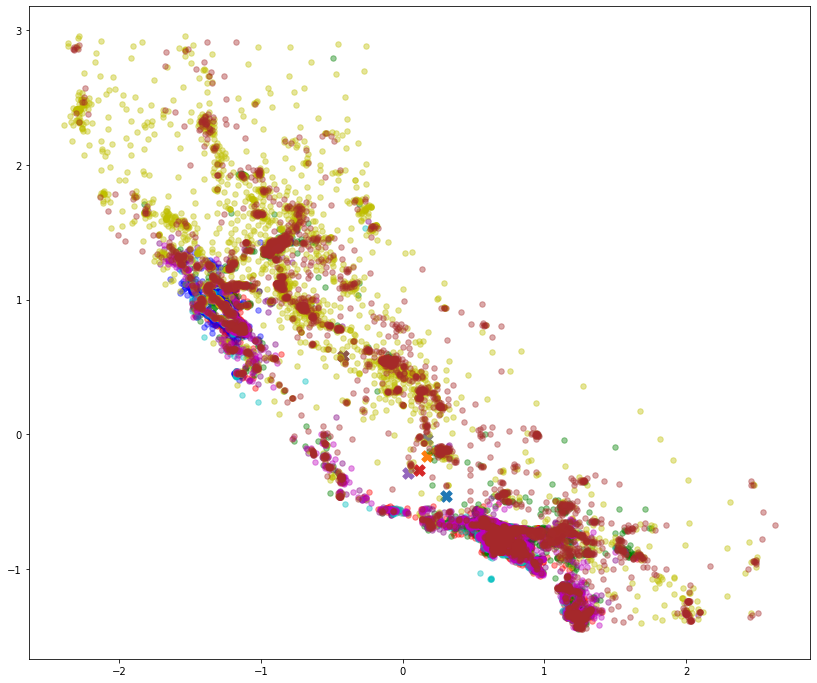

In [ ]:
plot_graphs(cluster7)

In [ ]:
cluster8 = k_means(k=9)
cluster8.fit(housing_prepared)
elbow.append(cluster8.find_SSE())
print("Centroids: ", cluster8.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 0.30511586, -0.45592761, -0.4927432 ,  0.26037381, -0.18112618,
       -0.15925574, -0.16093105,  2.53531195,  1.9467598 ,  0.70557851,
        0.08780992,  0.        ,  0.03615702,  0.17045455]), 1: array([ 0.25654714, -0.22652639, -0.96642195,  2.37191481,  2.45146435,
        2.26002096,  2.44101147,  0.15089132,  0.10304501,  0.48082775,
        0.34814364,  0.        ,  0.07060256,  0.10042605]), 2: array([-1.2422284 ,  0.87851289,  0.96520736, -0.2933436 , -0.52475891,
       -0.5687457 , -0.50401527,  1.61758849,  1.86709722,  0.15541601,
        0.04238619,  0.        ,  0.62009419,  0.18210361]), 3: array([ 0.59052055, -0.69457588, -0.13759186, -0.25834543, -0.41291358,
       -0.34346396, -0.38045468,  0.68467718,  0.37326134,  0.8359596 ,
        0.06545455,  0.        ,  0.00686869,  0.09171717]), 4: array([ 0.63429396, -0.7934761 ,  0.85081404, -0.344694  , -0.29701523,
       -0.49863996, -0.29811259,  0.07535115,  1.5464456 ,  0.68534907,
        

In [ ]:
print("SSE: " + str(cluster8.find_SSE()))
data_report(cluster8.cluster_mean(), 'means')
data_report(cluster8.cluster_stdev(), 'stdev')

SSE: 2207.9517217265143
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1       0.305116    -0.455928      -0.492743         0.260374           -0.181126       -0.159256    -0.160931          2.53531                 1.94676         0.705579       0.0878099      0               0.036157        0.170455
cluster 2       0.256547    -0.226526      -0.966422         2.37191             2.45146         2.26002      2.44101           0.150891                0.103045        0.480828       0.348144       0               0.0706026       0.100426
clu

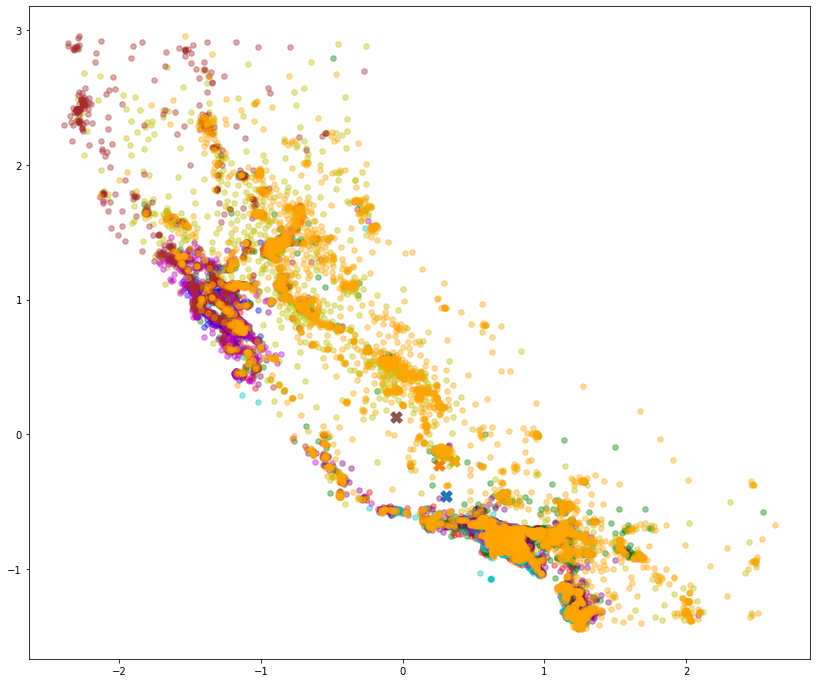

In [ ]:
plot_graphs(cluster8)

In [ ]:
cluster9 = k_means(k=10)
cluster9.fit(housing_prepared)
elbow.append(cluster9.find_SSE())
print("Centroids: ", cluster9.centroids)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Centroids:  {0: array([ 0.55618834, -0.69074975, -0.30710087,  0.3134441 , -0.16570954,
       -0.14721008, -0.14393553,  2.7976401 ,  2.10970585,  0.75613276,
        0.06204906,  0.        ,  0.004329  ,  0.17748918]), 1: array([ 0.23826926, -0.18653592, -1.11520123,  3.65460085,  3.65628349,
        3.42271092,  3.64272065,  0.25793351,  0.10199174,  0.43930636,
        0.39450867,  0.        ,  0.08526012,  0.08092486]), 2: array([-1.30081426,  0.93386699,  0.46766344, -0.19509316, -0.47054698,
       -0.49504406, -0.44468858,  1.86473982,  1.91338243,  0.22687861,
        0.05635838,  0.        ,  0.52890173,  0.18786127]), 3: array([ 0.80999923, -0.87843011, -0.39608943, -0.20821734, -0.32463816,
       -0.26795274, -0.30110557,  0.51770518,  0.21968318,  0.79107425,
        0.07503949,  0.        ,  0.        ,  0.13388626]), 4: array([ 0.64005104, -0.79527896,  0.89076674, -0.27466322, -0.28264835,
       -0.45250784, -0.27329667,  0.38035949,  1.53118156,  0.7352459 ,
        

In [ ]:
print("SSE: " + str(cluster9.find_SSE()))
data_report(cluster9.cluster_mean(), 'means')
data_report(cluster9.cluster_stdev(), 'stdev')

SSE: 1495.2626384566072
Feature Means:
Cluster:      Longitude:    latitude:    Median Age:    Total # Rooms:    Total # Bedrooms    Population:    Houseolds:    Median Income:    Median House Value:    Ocean Prox1:    Ocean Prox2:    Ocean Prox3:    Ocean Prox4:    OceanProx5:
----------  ------------  -----------  -------------  ----------------  ------------------  -------------  ------------  ----------------  ---------------------  --------------  --------------  --------------  --------------  -------------
cluster 1       0.556188   -0.69075        -0.307101         0.313444           -0.16571       -0.14721      -0.143936           2.79764               2.10971         0.756133        0.0620491     0               0.004329         0.177489
cluster 2       0.238269   -0.186536       -1.1152           3.6546              3.65628        3.42271       3.64272            0.257934              0.101992        0.439306        0.394509      0               0.0852601        0.0809249
cl

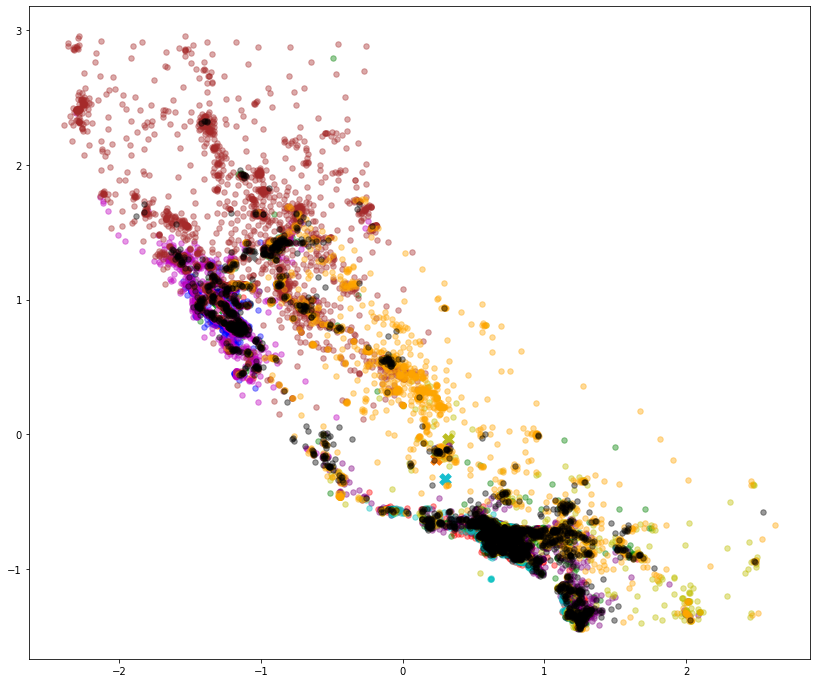

In [ ]:
plot_graphs(cluster9)

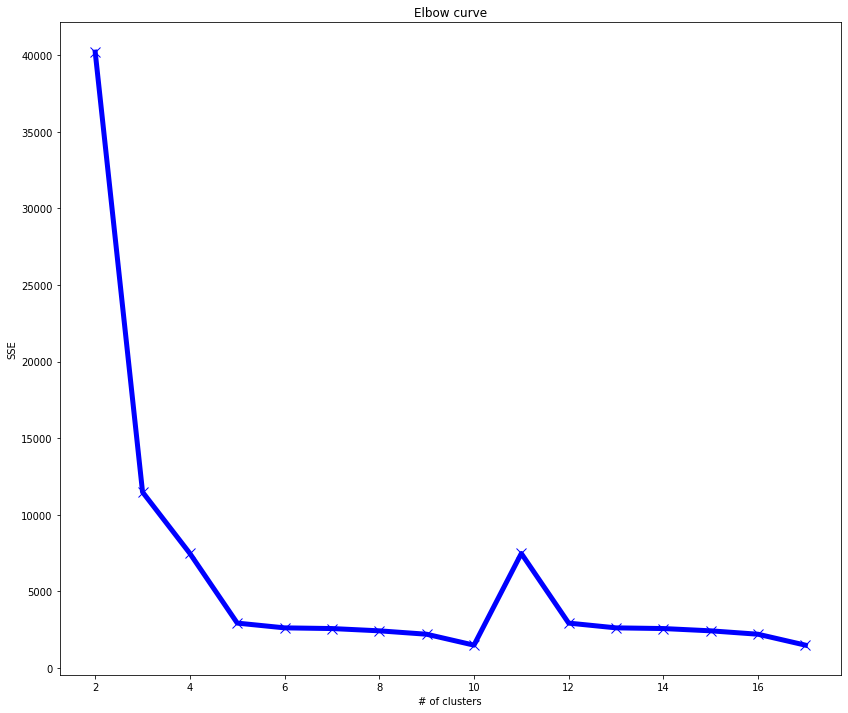

In [ ]:
plt.figure(figsize=(14,12))
plt.plot(np.arange(2,len(elbow)+2),elbow,marker='x',markerfacecolor='r',markersize=10,lw=5,color='blue')
plt.title('Elbow curve')
plt.xlabel('# of clusters')
plt.ylabel('SSE')
plt.show()

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



In [ ]:
'''
This code assignment was interesting. The actual process of coding up k-means clustering was easier than I thoguht. I was able to get the clusters and wverthing worling just fine. The only
issue I ran into was that my clusters were not as defined and there would at times be almost too much over lap. This may be to my specific implementation fo k-means. But as more and mroe clusters were
created you could see how various cluster would form overtop tbig cities such as San Francisco and Los Angeles. This would make sense as these are two of the biggest cities in California so there would me many poeple there. 
Also it seems like there were cluster overtop of scillicoln valley which would focus on the large population in the valley. The way this worked when we kept on adding clusters was that each cluster would break each 
city down more and mroe after a ceratyin point. Which is where the elbow curve comes in. It seems that the elbow for the data lies between 3 and 4 clusters. which makes sense as any mroe and it just starts to cluster cities in 
odd ways. One possibel way the clustering could imporcve is by setting the strating centroids as random as opposed to the first optwo point in the data. While it would remove sopme consistency, it could allow for possibly better generated clusters.
'''

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Best of luck and have fun!